## Adi-reader

### V1

In [35]:
import adi
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [36]:
#path = r'..\uploaded_files\archivo_de_prueba.adicht' # Cambiar la ruta al archivo
path = r".\AFT_20241126_188-PA.adicht"  # Cambiar la ruta al archivo

f = adi.read_file(path)
f

file_loaded: True
          h: <cdata 'struct ADI_FileHandle__ * *' owning 8 bytes>
  n_records: 1
 n_channels: 14
    records: Type::list, Len: 1
   channels: Type::list, Len: 14

In [37]:
f.channels[2]

        h: <cdata 'struct ADI_FileHandle__ * *' owning 8 bytes>
       id: 3
n_records: 1
  tick_dt: [0.0001]
  records: Type::list, Len: 1
     name: ECG
    units: ['V']
n_samples: [7119000]
       dt: [0.001]
       fs: [1000.0]

In [38]:
for ch in f.channels:
    n_samples = sum(ch.n_samples)
    fs_ch = ch.fs[0]
    print(f"{ch.name.strip()}: n_samples/fs = {n_samples/fs_ch:.2f} s para {n_samples} muestras a {fs_ch} Hz")

BioAmp raw: n_samples/fs = 7119.00 s para 71190000 muestras a 10000.0 Hz
HR: n_samples/fs = 7119.00 s para 711900 muestras a 100.0 Hz
ECG: n_samples/fs = 7119.00 s para 7119000 muestras a 1000.0 Hz
FBP: n_samples/fs = 7119.00 s para 711900 muestras a 100.0 Hz
Valsalva: n_samples/fs = 7119.00 s para 711900 muestras a 100.0 Hz
CO: n_samples/fs = 7119.00 s para 711900 muestras a 100.0 Hz
SV: n_samples/fs = 7119.00 s para 711900 muestras a 100.0 Hz
SVR: n_samples/fs = 7119.00 s para 711900 muestras a 100.0 Hz
ETCO2: n_samples/fs = 7119.00 s para 711900 muestras a 100.0 Hz
SPO2: n_samples/fs = 7119.00 s para 711900 muestras a 100.0 Hz
MCA-L: n_samples/fs = 7119.00 s para 711900 muestras a 100.0 Hz
MCA-R: n_samples/fs = 7119.00 s para 711900 muestras a 100.0 Hz
Tilt Angle: n_samples/fs = 7119.00 s para 711900 muestras a 100.0 Hz
MAP: n_samples/fs = 7119.00 s para 711900 muestras a 100.0 Hz


In [39]:
for i in range(f.n_channels):
    print(f.channels[i].name)
    

BioAmp raw
HR
ECG
FBP
Valsalva
CO
SV
SVR
ETCO2
SPO2
MCA-L
MCA-R
Tilt Angle
MAP


In [40]:
f = adi.read_file(path)
channel_names = [ch.name.strip() for ch in f.channels][1:]
print(channel_names)

channel_data = []
for ch in f.channels[1:]:
    for r in range(ch.n_records):
        ch.get_data(r+1)

['HR', 'ECG', 'FBP', 'Valsalva', 'CO', 'SV', 'SVR', 'ETCO2', 'SPO2', 'MCA-L', 'MCA-R', 'Tilt Angle', 'MAP']


In [41]:
# Leer archivo solo si es necesario (ya está cargado en 'f' y 'path')
# Obtener nombres de canales (excepto el primero)

channel_names = [ch.name.strip() for ch in f.channels][1:]

channel_data = []
max_len = 0
fs = 1000

# Concatenar todos los records de cada canal y calcular longitud máxima

for ch in f.channels[:]:
    data_segments = []
    for i in range(ch.n_records):
        try:
            data_segments.append(ch.get_data(i+1))
        except Exception as e:
            print(f"Warning: Could not retrieve data for channel '{ch.name.strip()}', record {i}: {e}")
            
    if data_segments:
        data = np.concatenate(data_segments)
        channel_data.append(data)

        if len(data) > max_len:
            max_len = len(data)
        if fs is None:
            fs = ch.fs[0]
    else:
        channel_data.append(np.array([]))

# Rellenar con NaN para igualar longitudes
channel_data_padded = [
    np.pad(data, (0, max_len - len(data)), constant_values=np.nan)
    for data in channel_data
]

# Generar columna Time usando fs
time = np.arange(max_len) / fs if fs else np.arange(max_len)

df_channels = pd.DataFrame(
    {name: data for name, data in zip(channel_names, channel_data_padded)}
)
df_channels.insert(0, "Time", time)

df_channels

,Time,HR,ECG,FBP,Valsalva,CO,SV,SVR,ETCO2,SPO2,MCA-L,MCA-R,Tilt Angle,MAP
0,0.000,0.003691,208.84375,-0.024688,98.06250,0.06250,5.175000,75.199997,771.732483,31.934063,100.886871,15.23250,45.697498,-142.68750
1,0.001,0.004395,208.90625,-0.038750,97.56250,0.06250,5.171875,75.187500,772.065002,31.940937,100.873123,17.58000,45.697498,-191.37500
2,0.002,0.005977,208.96875,-0.038750,97.03125,0.09375,5.178125,75.187500,771.566223,31.944374,100.797501,19.92000,44.523750,-93.43750
3,0.003,0.009492,209.00000,-0.031875,96.56250,0.12500,5.175000,75.199997,771.898743,31.923750,100.787186,24.60000,43.357498,-210.53125
4,0.004,0.009844,209.03125,-0.023438,95.93750,0.03125,5.178125,75.199997,771.732483,31.896250,100.794060,25.77375,44.527500,-118.81250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71189995,71189.995,0.030938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71189996,71189.996,0.025313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71189997,71189.997,0.023555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71189998,71189.998,0.023027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
# Código para leer un archivo .adicht usando la librería adi_reader
# y convertirlo en una estructura similar a la del archivo LoadLabChartFile.m

import numpy as np
from scipy.signal import find_peaks
import adi


class TraceSignal:
    def __init__(self):
        self.Name = ''
        self.Animal = 'Human'
        self.EBL = None
        self.Units = ''
        self.RawFileType = 'Labchart'
        self.PreProcess = ''
        self.RawDataRow = 1
        self.Marker = []
        self.MarkerData = []
        self.BB = []
        self.AB = []
        self.ProData = []
        self.TimeSec = []
        self.EU = ''
        self.TSRf = 0   # True Sampling rate float
        self.TSR = 0    # True sampling rate int
        self.SRD = 1
        self.SX = 0
        self.EX = 0
        self.Resampled = 0
        self.FMxI = []
        self.NFEE = []
        self.FEE = []
        self.TimeShift = 0


class Trace:
    def __init__(self):
        self.Signal = []
        self.ProFileName = ''
        self.FileName = ''
        self.SignalIndex = 0
        self.EBL = 0
        self.FMxI = []
        self.FEE = []
        self.NFEE = []
        self.EMS = []
        self.ECGSI = 0


class EMSComment:
    def __init__(self, seconds, comment, number):
        self.DateTime = ""
        self.Seconds = seconds
        self.Comment = comment
        self.CommentNum = number
        self.CommentBoxText = f"{comment:<50}{seconds:.2f}"


def detect_r_peaks(ecg_signal, fs):
    # Sencillo procesamiento de picos R
    ecg_abs = np.abs(ecg_signal - np.mean(ecg_signal))
    threshold = np.percentile(ecg_abs, 95)
    peaks, _ = find_peaks(ecg_abs, height=threshold, distance=int(0.25 * fs))
    return peaks


def load_labchart_adicht_extended(file_path, gap_length=3):
    file_data = adi.read_file(file_path)
    trace = Trace()
    trace.ProFileName = file_path.split("\\")[-1]
    trace.FileName = trace.ProFileName.split(".")[0]

    total_records = file_data.n_records
    assumed_tsr = None

    for i, channel in enumerate(file_data.channels):
        signal = TraceSignal()
        signal.Name = channel.name
        signal.Units = channel.units
        signal.TSRf = channel.fs[0]
        signal.TSR = int(round(signal.TSRf))
        signal.EU = signal.Units

        assumed_tsr = assumed_tsr or signal.TSR
        full_data = []

        for record_id in range(1, total_records + 1):
            data = channel.get_data(record_id)
            if data is not None:
                full_data.append(data)
                if record_id < total_records:
                    full_data.append(np.zeros(gap_length * signal.TSR))  # insert gap

        full_data = np.concatenate(full_data)
        signal.BB = full_data[:signal.TSR]
        signal.AB = full_data[-signal.TSR:]
        signal.ProData = full_data[signal.TSR:-signal.TSR]
        n_samples = len(signal.ProData)
        signal.TimeSec = np.linspace(1 / signal.TSR, n_samples / signal.TSR, n_samples)

        trace.Signal.append(signal)

    for i, sig in enumerate(trace.Signal):
        if 'ECG' in sig.Name.upper():
            trace.SignalIndex = i
            trace.ECGSI = i
            break
    else:
        trace.SignalIndex = 0
        trace.ECGSI = 0

    ecg_signal = trace.Signal[trace.ECGSI]
    ecg_full = np.concatenate([ecg_signal.BB, ecg_signal.ProData, ecg_signal.AB])
    peaks = detect_r_peaks(ecg_full, ecg_signal.TSR)
    trace.FMxI = peaks
    trace.Signal[trace.ECGSI].FMxI = peaks

    rr_intervals = np.diff(peaks)
    valid_rr = rr_intervals[(peaks[1:] > 200) & (peaks[1:] < len(ecg_full) - 200)]
    trace.CL = valid_rr
    trace.CLI = peaks[1:len(valid_rr)+1]
    trace.CLT = trace.CLI / ecg_signal.TSR

    trace.EBL = ecg_signal.TSR

    # Asignar comentarios por señal (canal)
    for ch_idx, ch in enumerate(f.channels):
        signal_comments = []
        for rec_idx, rec in enumerate(ch.records):
            if hasattr(rec, "comments") and rec.comments:
                for idx, c in enumerate(rec.comments):
                    tick_dt = getattr(c, 'tick_dt', 1.0 / ch.fs[rec_idx] if hasattr(ch, 'fs') else 1.0)
                    tick_pos = getattr(c, 'tick_position', 0)
                    seconds = tick_pos * tick_dt + rec_idx * ch.n_samples[rec_idx] * tick_dt
                    comment_str = getattr(c, 'str', '')
                    signal_comments.append(EMSComment(seconds, comment_str, idx + 1))
        if ch_idx < len(trace.Signal):
            trace.Signal[ch_idx].MarkerData = signal_comments

    return trace

In [46]:
prueba= load_labchart_adicht_extended(path)

prueba.Signal

In [ ]:
def plot_ecg_with_r_peaks_and_comments(trace):
    import matplotlib.pyplot as plt

    ecg_signal = trace.Signal[trace.ECGSI]
    fs = ecg_signal.TSR
    ecg_full = np.concatenate([ecg_signal.BB, ecg_signal.ProData, ecg_signal.AB])
    time = np.arange(len(ecg_full)) / fs
    r_peaks = trace.FMxI

    plt.figure(figsize=(16, 5))
    plt.plot(time, ecg_full, label='ECG')
    plt.plot(time[r_peaks], ecg_full[r_peaks], 'ro', label='R Peaks')

    # Anotar comentarios específicos de la señal
    for comment in ecg_signal.MarkerData:
        t = comment.Seconds
        if 0 <= t < time[-1]:
            plt.axvline(t, color='purple', linestyle='--', alpha=0.5)
            plt.text(t, np.max(ecg_full)*0.8, comment.Comment[:20], rotation=90,
                     color='purple', fontsize=8, verticalalignment='top')

    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')
    plt.title('ECG con Picos R y Comentarios')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


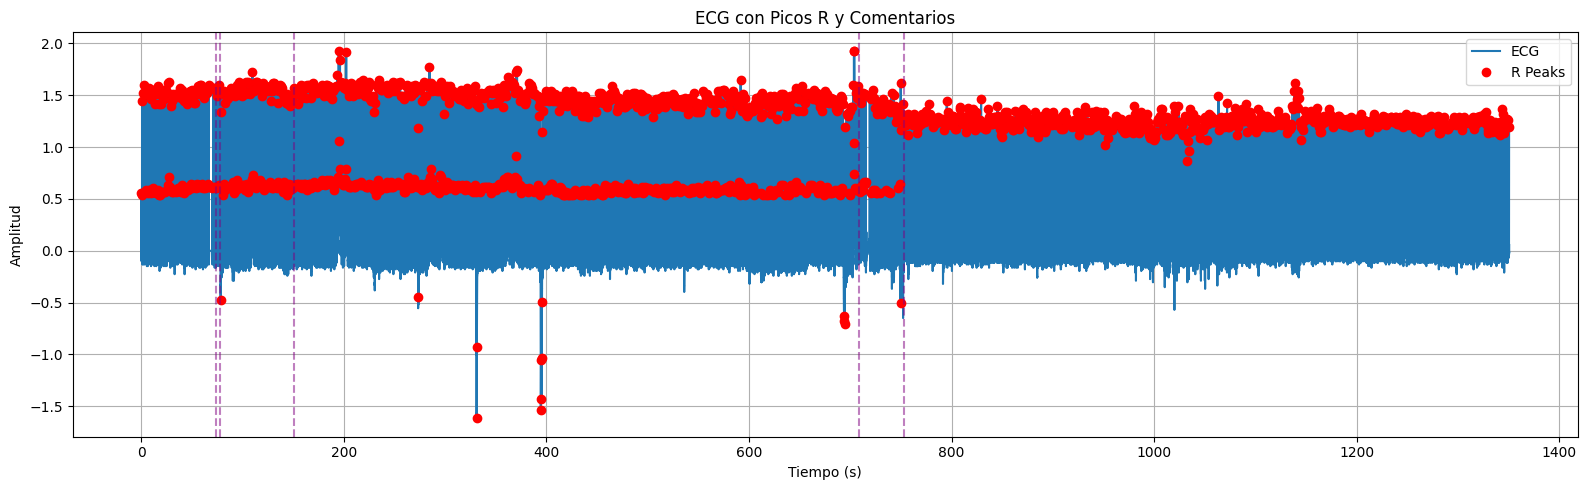

In [ ]:
plot_ecg_with_r_peaks_and_comments(prueba)

In [ ]:
import numpy as np
import pywt
trace = prueba

ecg_signal_obj = trace.Signal[trace.ECGSI]

ecg_raw = np.concatenate([ecg_signal_obj.BB, ecg_signal_obj.ProData, ecg_signal_obj.AB])
fs = ecg_signal_obj.TSR  # Frecuencia de muestreo

def wavelet_denoising(ecg_signal, wavelet='db6', level=5, threshold_scale=0.04):
    # Wavelet decomposition
    coeffs = pywt.wavedec(ecg_signal, wavelet, level=level)
    
    # Estimate noise threshold from detail coefficients at the first level
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    uthresh = threshold_scale * sigma * np.sqrt(2 * np.log(len(ecg_signal)))
    
    # Apply soft thresholding to detail coefficients
    denoised_coeffs = [coeffs[0]]  # approximation coefficients untouched
    for detail in coeffs[1:]:
        denoised = pywt.threshold(detail, value=uthresh, mode='soft')
        denoised_coeffs.append(denoised)
    
    # Reconstruct the signal from thresholded coefficients
    ecg_cleaned = pywt.waverec(denoised_coeffs, wavelet)
    
    # Ajustar el largo por si cambia al reconstruir
    ecg_cleaned = ecg_cleaned[:len(ecg_signal)]
    return ecg_cleaned


In [ ]:
print(type(ecg_signal))
print(ecg_signal.shape)

In [ ]:
ecg_denoised = wavelet_denoising(ecg_raw, wavelet='db6', level=5)

# Opcional: guardar dentro del objeto para uso futuro
ecg_signal_obj.Denoised = ecg_denoised


In [ ]:
import numpy as np
import plotly.graph_objects as go

# Suponiendo que ya tienes esto cargado:
# ecg_raw = np.concatenate([...])
# ecg_denoised = wavelet_denoising(ecg_raw)
# fs = frecuencia de muestreo

# Eje de tiempo
t = np.arange(len(ecg_raw)) / fs

# Crear figura
fig = go.Figure()

# Señal original (gris claro)
fig.add_trace(go.Scatter(
    x=t, y=ecg_raw, 
    mode='lines', 
    name='Original ECG', 
    line=dict(color='lightgray')
))

# Señal filtrada (rojo)
fig.add_trace(go.Scatter(
    x=t, y=ecg_denoised, 
    mode='lines', 
    name='Filtered ECG', 
    line=dict(color='red')
))

# Layout
fig.update_layout(
    title="Comparación de señal ECG: Original vs Filtrada",
    xaxis_title="Tiempo (s)",
    yaxis_title="Amplitud",
    legend=dict(x=0.01, y=0.99),
    height=500
)

fig.show()


### V2

In [47]:
from scipy.interpolate import make_interp_spline
import numpy as np

class Trace:
    
    def __init__(self, Name, ProData, TimeSec, Units, TSRf):

        self.Name = Name                              # Signal name
        self.Units = Units                            # Measurement units

        self.ProData = np.array(ProData)              # Main signal data
        self.TimeSec = np.array(TimeSec)              # Time vector

        self.BB = np.array([])                        # Pre-buffer (optional)
        self.AB = np.array([])                        # Post-buffer (optional)

        self.TSRf = float(TSRf)                       # Sampling rate (float)
        self.TSR = int(round(self.TSRf))              # Sampling rate (rounded)

        self.FMxI = []                                # Fiducial markers (optional)
        self.MarkerData = []                          # Comment annotations (optional)

    def __repr__(self):

        """Developer-facing representation (used in Jupyter, debugging, lists)."""
        duration = (
            round(self.TimeSec[-1] - self.TimeSec[0], 2)
            if len(self.TimeSec) > 1 else 0
        )
        return (
            f"<Signal '{self.Name}' | {len(self.ProData)} samples | "
            f"{self.TSRf:.2f} Hz | {duration} s | Units: {self.Units}>"
    )

    def __str__(self):
        """User-facing string, for printing a clean summary."""
        return f"Signal: {self.Name}, ({self.Units}) — {len(self.ProData)} samples"
    
    ### TODO 
    def __add__(self):
        #ADD signal
        pass


    def full_signal(self):
        """Return full signal including optional buffers."""
        return np.concatenate([self.BB, self.ProData, self.AB])



def interpolate(self, target_time, method='previous'):
    
    """
    Interpolate ProData to a new time base.

    Parameters:
        target_time (list or np.array): Desired time base to interpolate to
        method (str): Interpolation method
                      - 'previous': Zero-order hold (step-wise)

    Returns:
        np.array: Interpolated signal at target_time
    """
    if len(self.TimeSec) < 2:
        raise ValueError("TimeSec too short for interpolation.")
    
    if method == "previous":
        # Zero-order hold using spline of order 0
        spline = make_interp_spline(self.TimeSec, self.ProData, k=0)
        return spline(target_time)

    raise NotImplementedError(f"Interpolation method '{method}' is not implemented.")


    #def detect_peaks(self, threshold_percentile=95, min_distance_sec=0.25):
    #    """Detect peaks using thresholding."""
    #    x = np.abs(self.ProData - np.mean(self.ProData))
    #    threshold = np.percentile(x, threshold_percentile)
    #    distance = int(min_distance_sec * self.TSR)
    #    peaks, _ = find_peaks(x, height=threshold, distance=distance)
    #    self.FMxI = peaks
    #    return peaks


In [48]:
import numpy as np
import pywt
from scipy.signal import find_peaks

class ECGSignal(Trace):
    
    def __init__(self, Name, ProData, TimeSec, Units, TSRf):
        super().__init__(Name, ProData, TimeSec, Units, TSRf)
        
    def __repr__(self):
        return super().__repr__()

    def __str__(self):
        return super().__str__()

    def denoise_wavelet(self, scales=5, wavelet_name='haar'):
        fs = self.TSR
        ecg_signal = self.ProData

        # Step 1: CWT
        coeffs, _ = pywt.cwt(ecg_signal, scales=np.arange(1, scales+1), wavelet=wavelet_name, sampling_period=1/fs)
        D5 = coeffs[0]  # analogous to using scale 1 (like D5 in MATLAB)

        # Step 2: Adaptive threshold initialization
        minRdist = int(0.4 * fs)
        wind = D5[:fs*5]
        maximum = np.max(wind[10:])
        if maximum > 3 * np.median(np.abs(wind - np.median(wind))):
            wind = D5[4000:4000 + fs*5]
            maximum = np.max(wind[10:])

        minpeak = 0.4 * maximum
        _, locs = find_peaks(wind, height=minpeak, distance=minRdist)

        if len(locs) < 2:
            window_length = int(0.8 * fs)
        else:
            window_length = int(locs[0] + (locs[1] - locs[0]) / 2)

        adaptive_threshold = np.zeros_like(D5)
        i = 0

        for k in range(len(D5)):
            win_start = max(0, int(k - window_length / 2))
            win_end = min(len(D5), int(k + window_length / 2))
            energy_window = np.max(D5[win_start:win_end] ** 2)
            adaptive_threshold[k] = energy_window

            if k % (10 * fs) == 0 and k > 0:
                window_R = D5[i:k] ** 2
                window_T = adaptive_threshold[i:k]

                loc = np.where(window_R < window_T)[0]
                window_R[loc] = 0
                peaks, _ = find_peaks(window_R, distance=70)
                if len(peaks) > 1:
                    mean_distance = np.mean(np.diff(peaks))
                    if (k == 2500 and 80 <= mean_distance <= 300) or \
                       (k > 2500 and window_length * 0.75 <= mean_distance <= window_length * 1.25):
                        window_length = int(mean_distance)

                i = k + 1

        # Step 3: Tukey method to find outliers
        Q1, Q2, Q3 = np.percentile(adaptive_threshold, [25, 50, 75])
        IQR = Q3 - Q1
        lim_up = Q1 + 1.5 * IQR
        lim_low = Q1 - 1.5 * IQR

        atipics = np.zeros_like(adaptive_threshold)
        normal = np.zeros_like(adaptive_threshold)

        idx_atipics = adaptive_threshold >= lim_up
        atipics[idx_atipics] = adaptive_threshold[idx_atipics]
        normal[~idx_atipics] = adaptive_threshold[~idx_atipics]

        # Step 4: Apply thresholds
        D5_sq = D5 ** 2
        ecg_cleaned_A = D5_sq.copy()
        ecg_cleaned_N = D5_sq.copy()

        # Atipic suppression
        RR_A = np.where(atipics < adaptive_threshold)[0]
        ecg_cleaned_A[RR_A] = 0
        ecg_cleaned_A[ecg_cleaned_A < atipics] = 0

        # Normal suppression
        RR_N = np.where(normal < adaptive_threshold)[0]
        ecg_cleaned_N[RR_N] = 0
        ecg_cleaned_N[ecg_cleaned_N < normal * 0.95] = 0

        # Final cleaned signal
        ecg_cleaned = ecg_cleaned_A + ecg_cleaned_N

        return ecg_cleaned, atipics


In [49]:
import adi
import numpy as np

f = adi.read_file(path)

# Seleccionar canal ECG (busca por nombre)
ecg_channel = None

for ch in f.channels:
    if 'ecg' in ch.name.lower():
        ecg_channel = ch
        print("gola")
        break

if ecg_channel is None:
    raise ValueError("No ECG channel found")

# Concatenar todos los records
data_segments = [ecg_channel.get_data(i + 1) for i in range(ecg_channel.n_records)]
full_data = np.concatenate(data_segments)

# Construir vector de tiempo
fs = ecg_channel.fs[0]
time = np.linspace(1 / fs, len(full_data) / fs, len(full_data))


gola


In [51]:
ecg = ECGSignal(
    Name=ecg_channel.name,
    ProData=full_data,
    TimeSec=time,
    Units=ecg_channel.units[0],
    TSRf=fs
)
print(ecg)

Signal: ECG, (V) — 7119000 samples


##### Plot v1

In [53]:
from dash import Dash, dcc, html, Input, Output, State, ctx
import plotly.graph_objects as go
import numpy as np

# Ventana de 3 minutos
WINDOW_SECONDS = 180
fs = ecg.TSR                    # True sampling rate
max_time = ecg.TimeSec[-1]      # Max time of the signal

# App
app = Dash(__name__)
app.title = "ECG Viewer"

# Layout
app.layout = html.Div([
    html.H4("ECG Viewer", 
            style={"backgroundColor": "white", 
                   "padding": "10px"}),

    dcc.Graph(id='ecg-plot'),

    html.Div([
        html.Button("⏮ Previous", id="prev-btn", n_clicks=0),
        html.Button("Next ⏭", id="next-btn", n_clicks=0)], 
        style={"marginTop": "10px"}),

    # Slider interno dentro de la ventana
    dcc.Slider(
        id='local-slider',
        min=0,
        max=WINDOW_SECONDS,
        step=1,
        value=0,
        tooltip={"placement": "bottom", 
                 "always_visible": True},
        updatemode="drag"
    ),

    # Guarda el inicio de la ventana actual (global)
    dcc.Store(id="start-global", data=0),
])


# 🎥 Actualizar gráfico
@app.callback(
    Output("ecg-plot", "figure"),
    Input("local-slider", "value"),
    State("start-global", "data")
)
def update_plot(local_offset, start_global):
    start_time = start_global + local_offset
    end_time = start_time + 1  # Pequeño desplazamiento visible

    start_idx = int(start_time * fs)
    end_idx = int((start_global + WINDOW_SECONDS) * fs)

    x = ecg.TimeSec[start_idx:end_idx]
    y = ecg.ProData[start_idx:end_idx]

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x, y=y, mode='lines', name="ECG", line=dict(color="royalblue")))

    fig.update_layout(
        margin=dict(l=20, r=20, t=30, b=30),
        xaxis_title="Time (s)",
        yaxis_title=f"Amplitude ({ecg.Units})",
        template="plotly_white",
        height=400,
        xaxis=dict(range=[x[0], x[-1]] if len(x) > 1 else [0, 1]),
        yaxis=dict(range=[float(np.min(y)), float(np.max(y))])
    )
    return fig


# 🎮 Botones para avanzar ventanas completas
@app.callback(
    Output("start-global", "data"),
    Output("local-slider", "value"),
    Input("prev-btn", "n_clicks"),
    Input("next-btn", "n_clicks"),
    State("start-global", "data")
)
def shift_window(n_prev, n_next, start_global):
    triggered = ctx.triggered_id

    if triggered == "prev-btn":
        new_start = max(0, start_global - WINDOW_SECONDS)
    elif triggered == "next-btn":
        new_start = min(max_time - WINDOW_SECONDS, start_global + WINDOW_SECONDS)
    else:
        new_start = start_global

    return new_start, 0  # Resetea slider local

# Ejecutar inline en Jupyter
app.run(jupyter_mode="inline")

[2025-05-29 19:33:16,450] ERROR in app: Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "c:\Users\jor_x\Desktop\codes\Aurora\signal_viewer\env\Lib\site-packages\flask\app.py", line 1473, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jor_x\Desktop\codes\Aurora\signal_viewer\env\Lib\site-packages\flask\app.py", line 882, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jor_x\Desktop\codes\Aurora\signal_viewer\env\Lib\site-packages\flask\app.py", line 880, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jor_x\Desktop\codes\Aurora\signal_viewer\env\Lib\site-packages\flask\app.py", line 865, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)  # type: ignore[no-any-return]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^

#### Plot v2

In [54]:
# Supongamos que la variable `ecg` ya fue cargada previamente con adi.read_file()
from dash import Dash, dcc, html, Input, Output, State, ctx
import plotly.graph_objects as go
import numpy as np

# ---------------- Parámetros ----------------
WINDOW_SECONDS = 180        # Duración ventana fija (3 minutos)
LOCAL_VIEW_SECONDS = 20     # Tramo visible (como pan interno)
fs = ecg.TSR
max_time = ecg.TimeSec[-1]

# ---------------- App Dash ----------------
app = Dash(__name__)
app.title = "ECG Viewer"

app.layout = html.Div([
    html.H4("ECG Viewer", style={"backgroundColor": "white", "padding": "10px"}),

    dcc.Graph(id='ecg-plot'),

    html.Div([
        html.Button("⏮ Previous", id="prev-btn", n_clicks=0),
        html.Button("Next ⏭", id="next-btn", n_clicks=0)
        ], 
        style={"marginTop": "10px"}),

    dcc.Slider(
        id='local-slider',
        min=0,
        max=WINDOW_SECONDS - LOCAL_VIEW_SECONDS,
        step=1,
        value=0,
        tooltip={"placement": "bottom", "always_visible": True},
        updatemode="drag",
        persistence= True,
        persistence_type= "session",
        included= True
    ),

    dcc.Store(id="start-global", data=0),
])


@app.callback(
    Output("ecg-plot", "figure"),
    Input("local-slider", "value"),
    State("start-global", "data")
)
def update_plot(local_offset, start_global):
    start_time = start_global + local_offset
    end_time = start_time + LOCAL_VIEW_SECONDS

    start_idx = int(start_time * fs)
    end_idx = int(end_time * fs)

    x = ecg.TimeSec[start_idx:end_idx]
    y = ecg.ProData[start_idx:end_idx]

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x, y=y, mode='lines', name="ECG", line=dict(color="royalblue")))

    fig.update_layout(
        margin=dict(l=20, r=20, t=30, b=30),
        xaxis_title="Time (s)",
        yaxis_title=f"Amplitude ({ecg.Units})",
        template="plotly_white",
        height=400,
        xaxis=dict(range=[x[0], x[-1]] if len(x) > 1 else [0, 1]),
        yaxis=dict(range=[float(np.min(y)), float(np.max(y))] if len(y) else [-1, 1])
    )
    return fig


@app.callback(
    Output("start-global", "data"),
    Output("local-slider", "value"),
    Input("prev-btn", "n_clicks"),
    Input("next-btn", "n_clicks"),
    State("start-global", "data")
)
def shift_window(n_prev, n_next, start_global):
    triggered = ctx.triggered_id
    if triggered == "prev-btn":
        new_start = max(0, start_global - WINDOW_SECONDS)
    elif triggered == "next-btn":
        new_start = min(max_time - WINDOW_SECONDS, start_global + WINDOW_SECONDS)
    else:
        new_start = start_global
    return new_start, 0

# Ejecutar inline en Jupyter
app.run(jupyter_mode="inline")


## Dash

#### Dropdown

In [10]:
from dash import html, dcc

def dropdown_menu(dropdown_name : str,dropdown_children : list):
    
    return html.Div(
        style={"position": "relative", 
               "display": "inline-block", 
               "marginLeft": "20px"},
        
        children =[
            #Button
            html.Button(
                # CSS style for the button
                style={
                "backgroundColor": "#f8f9fa",
                "border": "1px solid #ccc",
                "padding": "10px",
                "cursor": "pointer"
                },
                #Component
                children=[dropdown_name+" ▾"], 
                id=f"dropdown-{dropdown_name}-button", 
                n_clicks=0
                ),

            #Dropdownmenu
            html.Div(
                # CSS style for the hidden droplist 
                style={
                    "display": "none",  # Hidden by default
                    "position": "absolute",
                    "backgroundColor": "#f8f9fa",
                    "border": "1px solid #ccc",
                    "minWidth": "160px",
                    "zIndex": "1",
                    "marginTop": "5px",
                    "boxShadow": "0px 8px 16px 0px rgba(0,0,0,0.2)"
                },
                #  Actions 
                children = dropdown_children,
                id="dropdown-content"
            )
        ]
    )



In [20]:

dropmenu_children_test = [
    html.Button(
        "📂 Load File", 
        id="btn-load-file", 
        style={
            "width" : "100%",
            "padding" : "10px"
        }
    ),
    html.Button(
        "💾 Save File", 
        id="btn-save-file", 
        style={
            "width"   : "100%",
            "padding": "10px"

        }
    ),
    html.Button(
        "💾 Export", 
        id="btn-export-file", 
        style={
            "width"   : "100%",
            "padding": "10px"             
        }
    )]

In [29]:
print(f"fs: {fs}")
print(f"len(ProData): {len(ecg.ProData)}")
print(f"len(TimeSec): {len(ecg.TimeSec)}")
print(f"Último tiempo: {ecg.TimeSec[-1]}")
print(f"Max end_idx: {(ecg.TimeSec[-1] - window_sec) * fs}")


fs: 1000.0
len(ProData): 7261600
len(TimeSec): 7261600
Último tiempo: 7261.6
Max end_idx: 7081600.0


In [31]:
start_idx = 0
end_idx = int(window_sec * fs)
print("Índices:", start_idx, "→", end_idx)
print("t (TimeSec):", ecg.TimeSec[start_idx:end_idx][:5])
print("y (ProData):", ecg.ProData[start_idx:end_idx][:5])
print("Mínimo Y:", np.nanmin(ecg.ProData[start_idx:end_idx]))
print("Máximo Y:", np.nanmax(ecg.ProData[start_idx:end_idx]))
print("Unidades:", ecg.Units)


Índices: 0 → 180000
t (TimeSec): [0.001 0.002 0.003 0.004 0.005]
y (ProData): [-0.0146875 -0.0246875 -0.0246875 -0.0246875 -0.0246875]
Mínimo Y: -0.15375
Máximo Y: 0.4834375
Unidades: V


In [32]:
type(ecg.TimeSec[0]), type(ecg.ProData[0])


(numpy.float64, numpy.float32)

In [37]:
from dash import Dash, dcc, html, Input, Output, State
import plotly.graph_objects as go
import numpy as np
import dash

# Parámetros base
fs = ecg.TSRf
window_sec = 60  # 1 minuto
max_start = (len(ecg.ProData) - int(window_sec * fs)) // int(fs)

# App Dash
app = Dash(__name__)

app.layout = html.Div([
    html.H4("ECG Viewer - 1 Minute Window", style={
        "backgroundColor": "white",
        "padding": "10px",
        "borderRadius": "6px",
        "marginBottom": "10px",
        "boxShadow": "0 2px 4px rgba(0,0,0,0.1)"
    }),
    dcc.Graph(id="ecg-graph"),
    html.Div([
        html.Button("⏮ Previous", id="prev-btn", n_clicks=0),
        html.Button("Next ⏭", id="next-btn", n_clicks=0),
    ], style={"marginTop": "10px", "display": "flex", "gap": "10px"}),
    dcc.Store(id="start-time", data=0)
])

@app.callback(
    Output("ecg-graph", "figure"),
    Output("start-time", "data"),
    Input("next-btn", "n_clicks"),
    Input("prev-btn", "n_clicks"),
    State("start-time", "data"),
    prevent_initial_call=False
)
def update_graph(n_next, n_prev, current_start):
    ctx = dash.callback_context
    triggered = ctx.triggered[0]['prop_id'].split('.')[0] if ctx.triggered else None

    if triggered == "next-btn" and current_start < max_start:
        current_start += window_sec
    elif triggered == "prev-btn" and current_start >= window_sec:
        current_start -= window_sec

    start_idx = int(current_start * fs)
    end_idx = min(start_idx + int(window_sec * fs), len(ecg.ProData))

    # Extraer señal original (sin modificarla)
    t = ecg.TimeSec[start_idx:end_idx]
    y = ecg.ProData[start_idx:end_idx]

    # Submuestreo visual solo para graficar (no modifica la señal original)
    max_points = 10000
    step = max(1, len(t) // max_points)
    t = t[::step]
    y = y[::step]

    # Rango Y usando percentiles
    y_trimmed = y[~np.isnan(y)]
    y_min = float(np.percentile(y_trimmed, 1))
    y_max = float(np.percentile(y_trimmed, 99))

    if y_max - y_min < 0.01:
        y_center = (y_max + y_min) / 2
        y_min = y_center - 0.05
        y_max = y_center + 0.05

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=t,
        y=y,
        mode="lines",
        name="ECG",
        line=dict(color="royalblue")
    ))
    fig.update_layout(
        title=f"ECG from {round(current_start)}s to {round(current_start + window_sec)}s",
        xaxis_title="Time (s)",
        yaxis_title=f"Amplitude ({ecg.Units})",
        height=400,
        yaxis=dict(range=[y_min, y_max]),
        margin=dict(l=50, r=50, t=40, b=40),
        template="plotly_white"
    )

    return fig, current_start

# Ejecutar inline en Jupyter
app.run(jupyter_mode="inline")


#### Navbar

#### Plot